I. Set Up

In [3]:
# PYTHON Imports 
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import math
import statistics
import matplotlib.pyplot as plt
from pathlib import Path
import glob
import ipywidgets as widgets
from IPython.display import clear_output
# ASTROPHY Imports
import astropy 
from astropy.table import Table
from astropy.io import fits
import astropy.stats.bayesian_blocks as bb
# CIAO Imports
import ciao_contrib.runtool
from ciao_contrib.runtool import *
# CUSTOM Imports
from data_extraction_functions import *
from data_exploration_functions import *
from data_representation_functions import *

# Specify global path
global_path = '/Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets'
global_folders = list_folders_fun(global_path)

# Select dataset
set_widget = widgets.Dropdown(options=global_folders[:],value=global_folders[1],description='Set :',disabled=False); set_widget

Dropdown(description='Set :', index=1, options=('All', 'Bona'), value='Bona')

II. Data Preparation

In [4]:
# # Set ID
# set_id = set_widget.value
# # Create region filtered files 
# region_filter_fun(global_path,set_id)
# # Create eventfile table
# create_eventfilestable_fun(global_path,set_id)
# # Combine all property tables with each other
# # dfp_list =[]
# # for prop_filename in glob.iglob(f'{global_path}/{set_id}/properties-{set_id}-*.csv'):
# #    dfp = pd.read_csv(prop_filename)
# #    dfp_list.append(dfp)
# # df_properties = pd.concat(dfp_list)
# # df_properties.to_csv(f'{global_path}/{set_id}/properties-{set_id}.csv',index=False)

# # Reduce data for useful input to data representation
# df_eventfiles = pd.read_csv(f'{global_path}/{set_id}/eventfiles-{set_id}.csv')
# df_properties = pd.read_csv(f'{global_path}/{set_id}/properties-{set_id}.csv')
# df_eventfiles_input, df_properties_input = data_reduction_fun(df_eventfiles, df_properties,global_path,set_id)



ValueError: No objects to concatenate

III. Load

In [4]:
from matplotlib.colors import LogNorm
from sherpa.astro import ui

# Set ID
set_id = set_widget.value

df_eventfiles_input = pd.read_csv(f'{global_path}/{set_id}/eventfiles-input-{set_id}.csv')
df_properties_input = pd.read_csv(f'{global_path}/{set_id}/properties-input-{set_id}.csv')

df_eventfiles_group = df_eventfiles_input.groupby('obsreg_id')
df_properties_group = df_properties_input.groupby('obsreg_id')

print("Number of Eventfiles: ", df_eventfiles_group.ngroups)
print("Number of Property Sets: ", df_properties_group.ngroups)


Number of Eventfiles:  82283
Number of Property Sets:  82283


In [22]:
def hist3D(df_eventfile_input, id_name, nbins_E, nbins_t, nbins_dt, plot = True, colmap = 'plasma'):
    # Copy df
    df = df_eventfile_input.copy()
    df.sort_values(by='time', inplace = True) 
    df.reset_index(drop=True, inplace = True)
    # Define histogram boundaries
    E_start = np.log10(500)
    E_end = np.log10(7000)
    t_start = 0
    t_end = 1
    dt_start = 0
    dt_end = 1
    # IDs
    obsid = id_name.split("_")[0]
    regid = id_name.split("_")[1]
    # Eventfile length and duration
    N_length = len(df) 
    T_duration = max(df["time"])-min(df["time"])
    # Add E, t, dt columns
    df["E"] = np.log10(df["energy"])
    df["t"] = (df["time"]-min(df["time"]))/(max(df["time"])-min(df["time"]))
    # df["delta_time"] = df['time'].diff().shift(-1)
    # df = df[df["delta_time"].notna()]
    # df["dt"] = (df['delta_time'] - df['delta_time'].mean()) / df['delta_time'].std() 
    # df["dt"] = (df["dt"]-min(df["dt"]))/(max(df["dt"])-min(df["dt"]))
    df["delta_time"] = df['t'].diff().shift(-1)
    df = df[df["delta_time"].notna()]
    df["dt"] = (df['delta_time']-min(df['delta_time']))/(max(df['delta_time'])-min(df['delta_time']))
    # Add Et histogram
    hist3D, edges = np.histogramdd((df["t"], df["E"], df["dt"]), range = [[t_start,t_end],[E_start, E_end], [dt_start, dt_end]],bins=(nbins_t,nbins_E, nbins_dt))
    # Create feature
    feature = hist3D
    # Plot
    if plot == True:
        fig = plt.figure(figsize=(10, 10),constrained_layout = True)
        fig.suptitle(f'ObsID: {obsid}, RegID: {regid}, N: {N_length}, T: {int(T_duration)}s')
        # Plot the E-t projection
        ax1 = fig.add_subplot(2, 2, 1)
        ax1.imshow(hist3D.sum(axis=2).T, origin='lower', extent=[t_start,t_end, E_start, E_end],cmap=colmap,norm=LogNorm())
        ax1.set_xlabel(r'$\tau$')
        ax1.set_ylabel(r'$\epsilon$')
        ax1.set_title(r'$\epsilon$ vs $\tau$ Projection')

        # Plot the dt-t projection
        ax2 = fig.add_subplot(2, 2, 2)
        ax2.imshow(hist3D.sum(axis=1).T, origin='lower', extent=[t_start,t_end, dt_start, dt_end],cmap=colmap,norm=LogNorm())
        ax2.set_xlabel(r'$\tau$')
        ax2.set_ylabel(r'$\delta\tau$')
        ax2.set_title(r'$\delta\tau$ vs $\tau$ Projection')

        # Plot the YZ projection
        ax3 = fig.add_subplot(2, 2, 3)
        ax3.imshow(hist3D.sum(axis=0), origin='lower', extent=[dt_start,dt_end, E_start, E_end],cmap=colmap,norm=LogNorm())
        ax3.set_xlabel(r'$\delta\tau$')
        ax3.set_ylabel(r'$\epsilon$')
        ax3.set_title(r'$\epsilon$ vs $\delta\tau$ Projection')

        # Plot 3D Histogram
        ax4 = fig.add_subplot(2, 2, 4, projection='3d')
        tt, EE, dtdt = np.meshgrid(edges[0][:-1], edges[1][:-1], edges[2][:-1], indexing='ij')
        tt = np.ravel(tt)
        EE = np.ravel(EE)
        dtdt = np.ravel(dtdt)
        h = np.ravel(hist3D)
        ax4.scatter(dtdt, tt, EE, s=250*h/max(h), alpha=0.5, edgecolors='none', c=h, cmap=colmap)
        ax4.set_xlabel(r'$\delta\tau$')
        ax4.set_ylabel(r'$\tau$')
        ax4.set_zlabel(r'$\epsilon$')
        ax4.set_title('3D Histogram')
        ax4.view_init(elev=30, azim=45)
        ax4.xaxis.set_ticks_position('bottom')
        ax4.yaxis.set_ticks_position('top')
        ax4.zaxis.set_ticks_position('bottom')
        ax4.invert_xaxis()
        plt.show()
    return feature


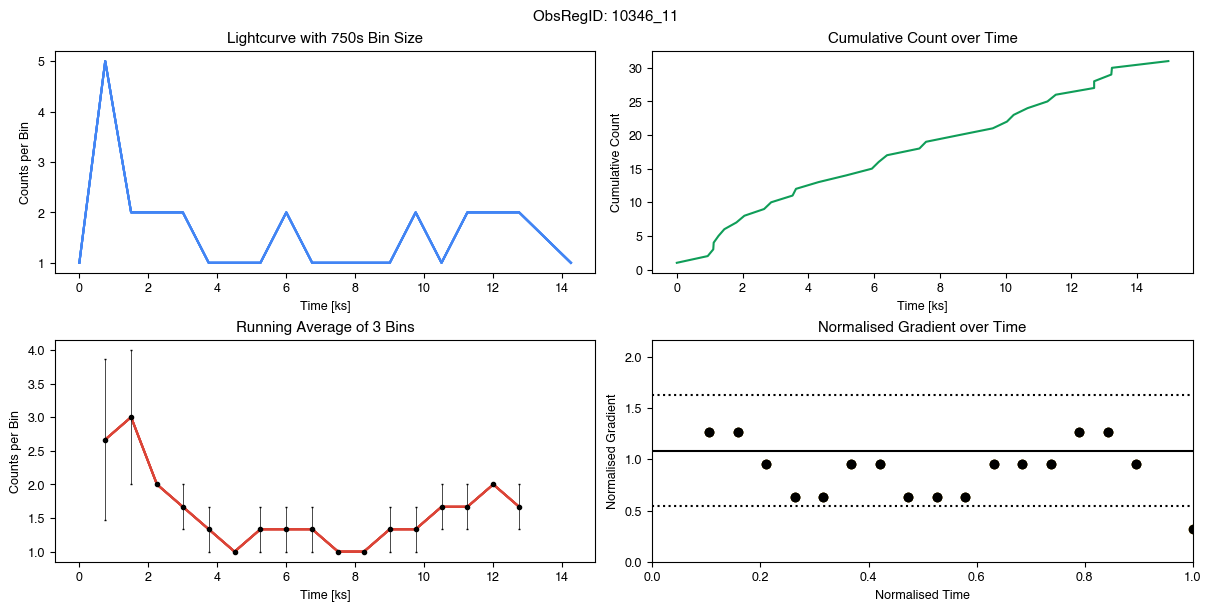

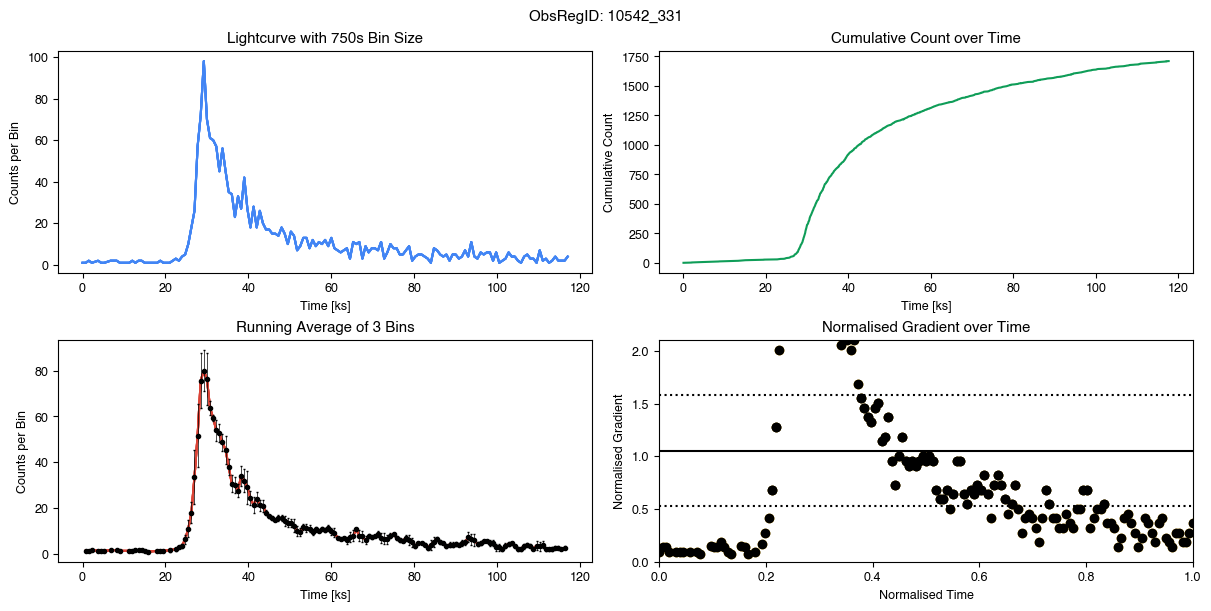

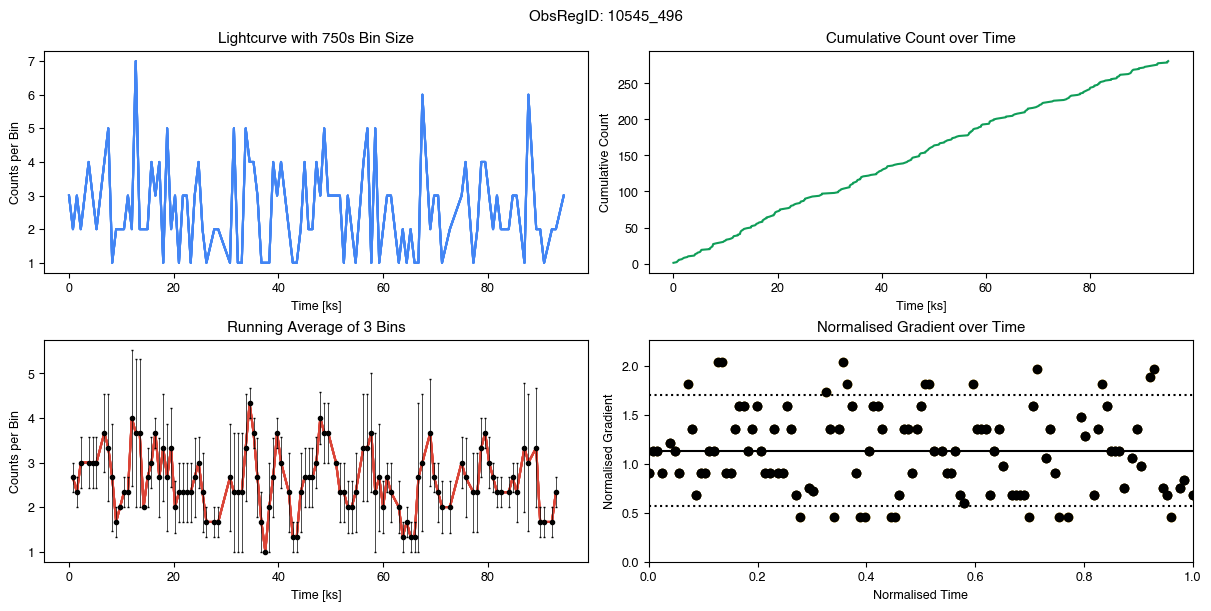

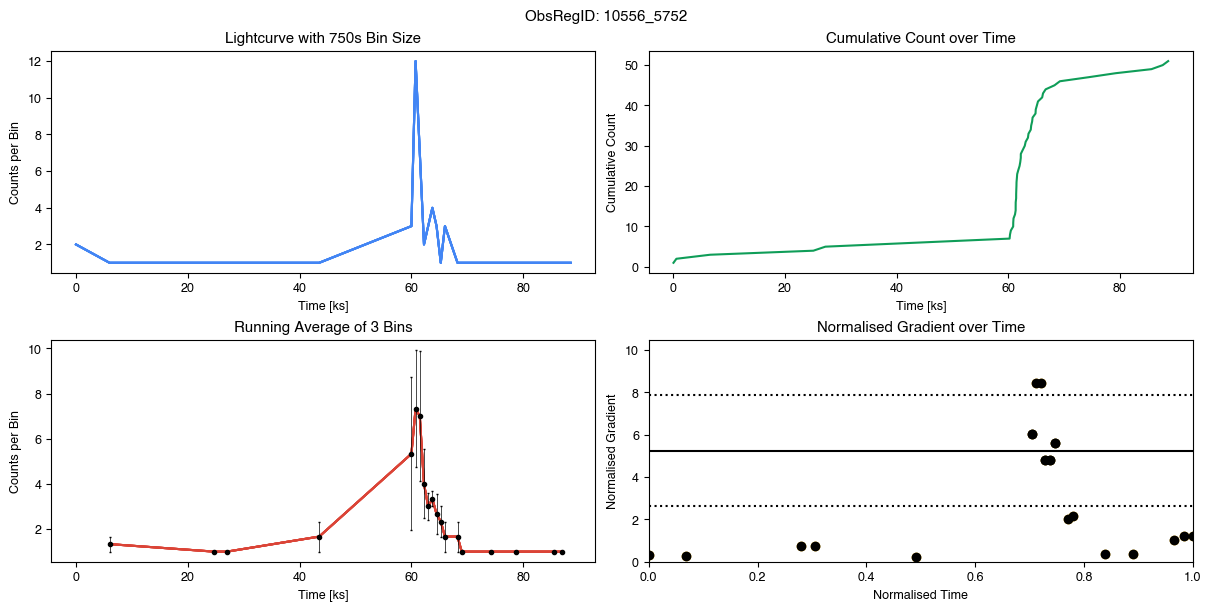

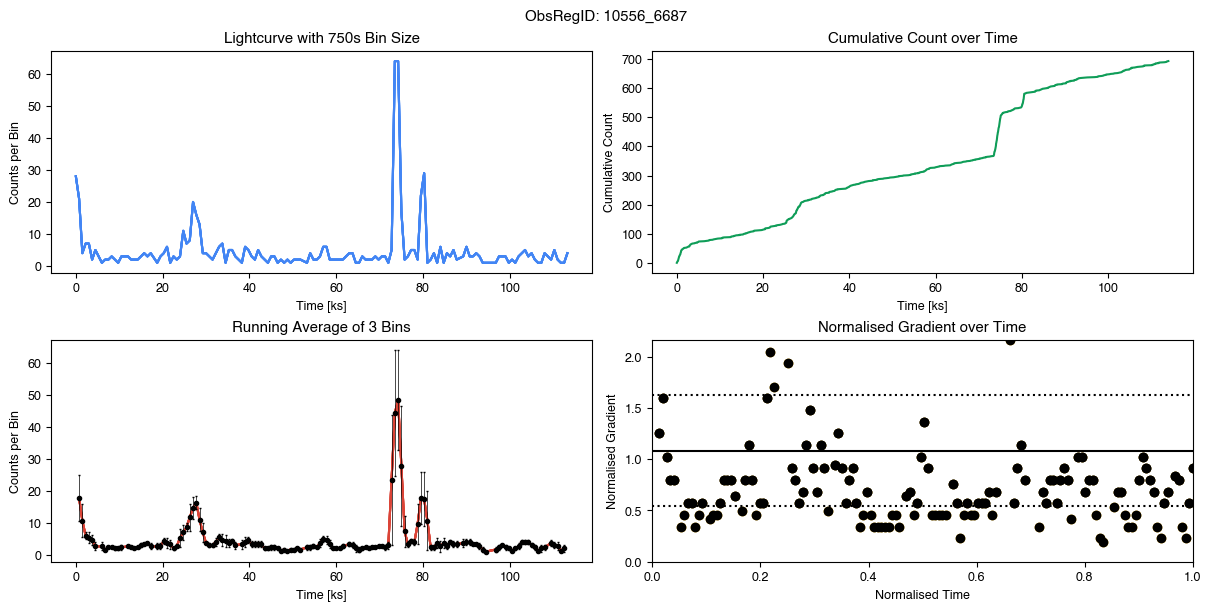

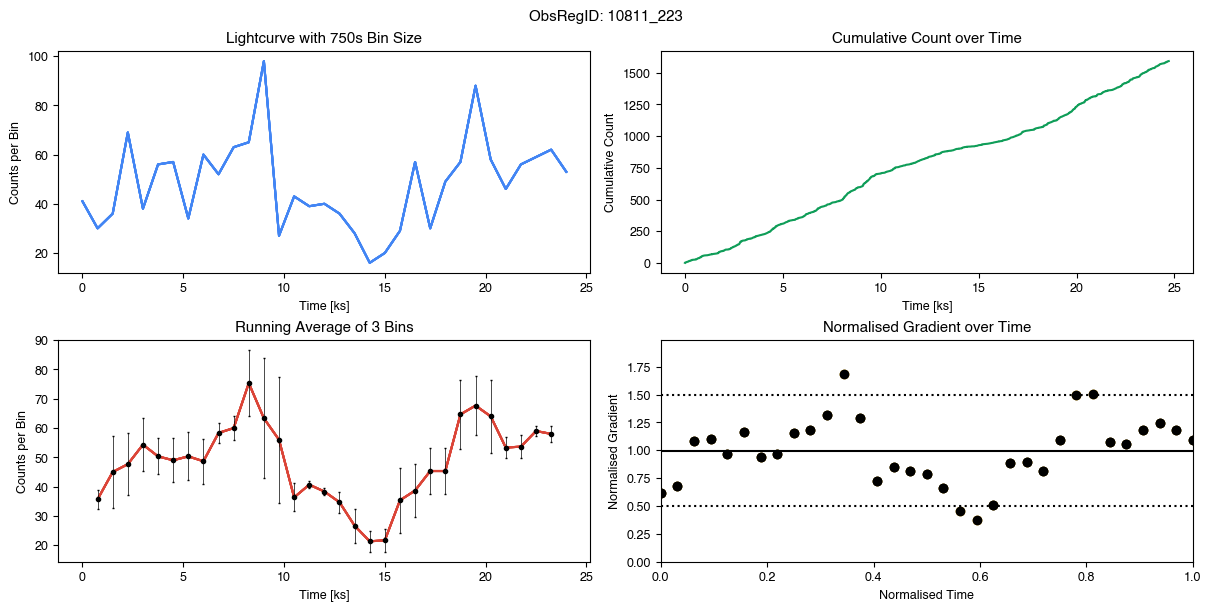

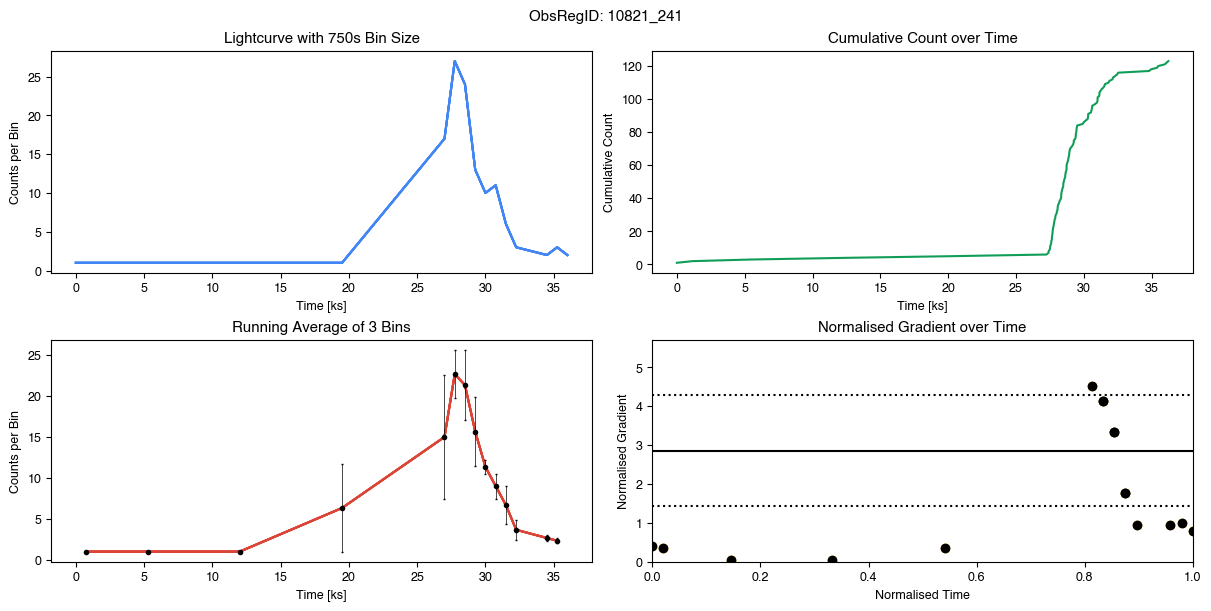

In [6]:
# Set ID
set_id = set_widget.value
# Filter for ObsRegIDs
all_ids = list(df_eventfiles_group.groups.keys())
flares = ['4395_992','16444_1025','2227_220','9518_47','9109_333','9109_344','13637_1078','14368_489','14368_503','14431_16','14542_18','10822_185','10955_21','10996_5','2833_53','13610_112','15214_29']
dips = ['10783_10','10871_10','11059_10','9070_10','9072_10','13814_567','13682_9','1708_192','1708_193','1712_91','15553_237','13681_9','13813_86']
fd22 = ['13814_567','13828_46','11092_46', '13252_46','13673_46','2225_46','2760_46','4736_46','2207_46','16235_46','14932_46','13711_46','13722_46','14361_46'] # ['10871_10','13814_567','15267_38','11016_168','1690_2']
#Filter for source
filtered_ids = [id for id in all_ids if id.split('_')[1] == '46']
# Filter here
filter = ['10346_11','10542_331','10542_331','10545_496','10556_5752','10556_6687','10811_223','10821_241'] #['10871_10','13814_567','14368_489','9109_333'] #flares # ['14368_489','14368_503','14431_16','14542_18']
#df_eventfiles_group_filtered = df_eventfiles_group.filter(lambda x: x.name in all_ids).groupby('obsreg_id')
df_eventfiles_group_filtered = df_eventfiles_group.filter(lambda x: x.name in filter).groupby('obsreg_id')
# Settings
Emin = np.log10(500)
Emax = np.log10(7000)
# E and dt binning
nbins_Eavg = 10 #19 #18
nbins_dtavg = 16  #32 #31
nbins_E75 = 11 #11 #10
nbins_dt75 = 21 #20 #18
nbins_E90 = 16 #15 #14
nbins_dt90 = 28 #27 #26
nbins_E95 = 20 #19 #18
nbins_dt95 = 33 #32 #31

nE = 17
ndt = 26
nt = 25

for id_name, dfi in df_eventfiles_group_filtered:
    dfi.sort_values(by='time', inplace = True) 
    dfi.reset_index(drop=True, inplace = True)
    lc_plotter_fun(dfi,id_name,750)
    hist2D_Et(dfi, id_name,nE, nt,norm = 'minmax',plot=True)
#     hist3D(dfi, id_name, nE, nt,ndt,plot=True)
#    # hist3D_2(dfi, id_name, nE, nt,ndt,dtscale = 'mm', plot=True)
  


In [8]:
yoyo  = ['10871_10','13814_567','10964_283','11013_79','11016_168']
interes = ['11272_13','11275_162','13814_567']
keep_obsreg = ['11389_67','11433_80','11467_1','11480_1','11479_11','11530_42','11541_94','11574_37','11574_98','11574_102','11579_12','11579_17','11587_1','11680_3']
keep_obsreg = ['11541_94','11587_1','11680_3']
keep_obsreg = ['11721_144','11737_157','11737_57','11737_59','11744_13','11744_8']
keep_obsreg = ['11744_13']
keep_obsreg = ['11751_30','11753_69','11780_26','11781_106','11781_95','11786_6','11790_25','11790_53','11792_12']
keep_obsreg = ['11801_13','11807_38','11840_67','11841_193','11841_584']
keep_obsreg = ['11988_38','12046_146'] #interesting
keep_obsreg = ['12328_839'] #interesting
keep_obsreg = ['12390_136'] #big flare!
keep_obsreg = ['12845_2'] 
keep_obsreg = ['12975_228','12975_450','12975_816','12976_810'] 
keep_obsreg = ['12992_101','12995_101'] # !!
keep_obsreg = ['13119_278'] 
keep_obsreg = ['13202_180'] 
keep_obsreg = ['13218_36'] 
keep_obsreg = ['13246_447','13252_409','13399_25'] #?
keep_obsreg = ['13428_201','13436_140'] 
keep_obsreg = ['13451_92','13452_46'] # INTERESTING DIP? 300
keep_obsreg = ['13500_112','13610_112','13611_34'] # BIG FLARE !!
bigf = ['13637_1078','13637_2287','13637_2689'] # BIG FLARE !!!!! and OSCILLATIONS
keep_obsreg = ['13681_9','13682_9'] # hmm same region source dips
keep_obsreg = ['13706_892'] # 
keep_obsreg = ['13713_3'] # 
keep_obsreg = ['13783_1738'] # 
keep_obsreg = ['13812_251'] # hmmm x2 weird
keep_obsreg = ['13812_586'] # DIP!!!
keep_obsreg = ['13813_218'] # rise
keep_obsreg = ['13813_86'] # dipp, large time no photons
keep_obsreg = ['13814_218','13814_237']
keep_obsreg = ['13815_567','13815_586','13815_269'] # 13815 ObsID lets go
# keep_obsreg = ['13814_567','13814_586','13814_86','13814_1103'] # 13814 ObsID lets go
keep_obsreg = ['13817_784','13825_596','13826_235'] # 3000 int symm flare
keep_obsreg = ['13828_46','13828_596'] # ohoho
keep_obsreg = ['13814_567','13814_586','13814_86','13814_1103']
keep_obsreg = ['13984_175']
keep_obsreg = ['14012_77']
keep_obsreg = ['14024_19']
keep_obsreg = ['14049_6'] # periodic
dipi= ['14196_34', '14196_426','14196_449'] # dip?! show rosanne
keep_obsreg = ['14195_37','14198_37'] # dip?! show rosanne
keep_obsreg = ['14198_480'] # ?
keep_obsreg = ['14334_2606','14334_2689'] # ? periodic
keep_obsreg = ['14335_986'] # FLARE
keep_obsreg = ['14342_101'] # DIP
keep_obsreg = ['14360_2'] # interesting dip, rosanne
rafael = ['14368_489','14368_503','14431_16','14542_18'] # very nice FLAREEE show rafael
keep_obsreg = ['14412_46','14436_54'] # 
keep_obsreg = ['14538_10'] # 
flaress = ['14545_26','14571_46','14581_3','14593_19','14625_892','14635_1','14668_58','14670_30'] # flares !!
keep_obsreg = ['14689_120','14814_37','14889_12','14895_80'] # boom flare
keep_obsreg = ['14897_574','14905_11']
keep_obsreg = ['14927_84','14930_35','14931_440'] # periodic?
keep_obsreg = ['14940_52','15214_29'] # yoo flare
keep_obsreg = ['14985_43'] # 10000
keep_obsreg = ['15099_16','15128_19'] # 
keep_obsreg = ['15229_18'] # 
keep_obsreg = ['1522_1269','1522_204','1522_3154','1522_627','1522_875'] # 1522
keep_obsreg = ['15267_38'] # dip GOOD DIP ask ROsanne!
keep_obsreg = ['1535_52','1535_58'] # 
f15393 = ['15393_122','15393_127','15393_302','15393_97'] # 15393 flares
keep_obsreg = ['15488_29'] # 
flare = ['15498_16','15546_945','15614_28'] # flare
keep_obsreg = ['15553_237','15578_31','15665_208'] # dips ask ROsanne
keep_obsreg = ['1586_233','1586_234','1595_57'] #  DIPS?
keep_obsreg = ['16182_174','1618_51'] #  DIPS hmmmmm
keep_obsreg = ['16192_133','16200_166','1690_2'] #  DIPS hmmmmm, last flare
keep_obsreg = ['1708_192','1708_193','1712_66','1712_91'] #  DIPS, blocked ask rosanne
yo = ['10871_10','13814_567','10964_283','11013_79','11016_168']
reg10 = ['10783_10','10871_10','11059_10','6976_10','7458_10','7686_10','7868_10','9070_10','9072_10','9569_10']
reg10_boom = ['4175_10','3057_10','4746_10','4178_10']
dipandflare = ['10871_10','13814_567','12390_136','13813_86','14368_489','14368_503','14431_16','14542_18']
dipandflare = ['10049_3','10059_245','10059_262']

In [12]:
def hist2D_representation_bonafide_fun3(df_eventfile_input, id_name, nbins_E, nbins_dt, nbins_t, dt_type='x3',pre_normalise = True, dt_normalise = True, lognorm = True):
    Emin = np.log(500)
    Emax = np.log(7000)
    # Copy df
    df = df_eventfile_input.copy()
    # IDs
    obsid = id_name.split("_")[0]
    regid = id_name.split("_")[1]
    # Eventfile length and duration for normalisation
    N_length = len(df) 
    T_duration = max(df["time"])-min(df["time"])
    # Add E, t column
    df["E"] = np.log(df["energy"])
    df["t"] = (df["time"]-min(df["time"]))/(max(df["time"])-min(df["time"]))
     # Add delta_time column
    df["delta_time"] = df['time'].diff().shift(-1)
    # normalise from -1 to 1
    if pre_normalise:
        df["delta_time"] = 2*(df["delta_time"]-min(df["delta_time"]))/(max(df["delta_time"])-min(df["delta_time"])) - 1
    # Add dt column
    if dt_type == 'x3':
        df["dt"] = ((df["delta_time"])) **3
    if dt_type == 'x2':
        df["dt"] = ((df["delta_time"])) **2
    if dt_type == 'x5':
        df["dt"] = ((df["delta_time"])) **5
    if dt_type == 'x7':
        df["dt"] = ((df["delta_time"])) **7
    if dt_type == 'x9':
        df["dt"] = ((df["delta_time"])) **9
    #print(df["dt"])
    if dt_normalise:
        dt_min = min(df["dt"])
        dt_max = max(df["dt"])
        df["dt"] = 2*(df["dt"]- dt_min)/(dt_max-dt_min)-1

    if lognorm:
        # Plot histograms
        fig,axs=plt.subplots(1,3,figsize=(12,2),constrained_layout = True)
        fig.suptitle(f'{dt_type}, (N: {N_length} counts, T: {T_duration}s)')
        plt.subplot(1, 3, 1)
        plt.title(f'E vs t for ID: {id_name}')
        Et = plt.hist2d(df["t"],df["E"],range = [[0,1],[Emin, Emax]],bins=(nbins_t,nbins_E),norm=LogNorm(),cmap = 'plasma') 
        plt.subplot(1, 3, 2)
        plt.title(f'E vs dt for ID: {id_name}')
        Edt = plt.hist2d(df["dt"],df["E"],range = [[-1,1],[Emin, Emax]],bins=(nbins_dt,nbins_E),norm=LogNorm(),cmap = 'plasma') 
        plt.subplot(1, 3, 3)
        plt.title(f'dt vs t for ID: {id_name}')
        dtt = plt.hist2d(df["t"],df["dt"],range = [[0,1],[-1,1]],bins=(nbins_t,nbins_dt),norm=LogNorm(),cmap = 'plasma') 
    else:
        # Plot histograms
        fig,axs=plt.subplots(1,3,figsize=(12,2),constrained_layout = True)
        fig.suptitle(f'{dt_type}, (N: {N_length} counts, T: {T_duration}s)')
        plt.subplot(1, 3, 1)
        plt.title(f'E vs t for ID: {id_name}')
        Et = plt.hist2d(df["t"],df["E"],range = [[0,1],[Emin, Emax]],bins=(nbins_t,nbins_E),cmap = 'plasma') 
        plt.subplot(1, 3, 2)
        plt.title(f'E vs dt for ID: {id_name}')
        Edt = plt.hist2d(df["dt"],df["E"],range = [[-1,1],[Emin, Emax]],bins=(nbins_dt,nbins_E),cmap = 'plasma') 
        plt.subplot(1, 3, 3)
        plt.title(f'dt vs t for ID: {id_name}')
        dtt = plt.hist2d(df["t"],df["dt"],range = [[0,1],[-1,1]],bins=(nbins_t,nbins_dt),cmap = 'plasma') 
        plt.show()
    return

In [15]:
def hist2D_representation_bonafide_fun4(df_eventfile_input, id_name, nbins_E, nbins_dt, nbins_t, dt_type='x3',pre_normalise = True, dt_normalise = True, lognorm = True):
    Emin = np.log(500)
    Emax = np.log(7000)
    # Copy df
    df = df_eventfile_input.copy()
    # IDs
    obsid = id_name.split("_")[0]
    regid = id_name.split("_")[1]
    # Eventfile length and duration for normalisation
    N_length = len(df) 
    T_duration = max(df["time"])-min(df["time"])
    # Add E, t column
    df["E"] = np.log(df["energy"])
    df["t"] = (df["time"]-min(df["time"]))/(max(df["time"])-min(df["time"]))
     # Add delta_time column
    df["delta_time"] = df['time'].diff().shift(-1)
    # normalise from -1 to 1
    if pre_normalise:
        df["delta_time"] = (2*(df["delta_time"]-min(df["delta_time"]))/(max(df["delta_time"])-min(df["delta_time"])) - 1)*10
    # Add dt column
    if dt_type == 'x3':
        df["dt"] = ((df["delta_time"])) **3
    elif dt_type == 'x5':
        df["dt"] = ((df["delta_time"])) **5
    elif dt_type == 'x7':
        df["dt"] = ((df["delta_time"])) **7
    elif dt_type == 'x9':
        df["dt"] = ((df["delta_time"])) **9
    elif dt_type == 'arctan':
        df["dt"] = np.arctan(df["delta_time"])
    #print(df["dt"])
    if dt_normalise:
        dt_min = min(df["dt"])
        dt_max = max(df["dt"])
        df["dt"] = 2*(df["dt"]- dt_min)/(dt_max-dt_min)-1

    if lognorm:
        # Plot histograms
        fig,axs=plt.subplots(1,3,figsize=(12,2),constrained_layout = True)
        fig.suptitle(f'{dt_type}, (N: {N_length} counts, T: {T_duration}s)')
        plt.subplot(1, 3, 1)
        plt.title(f'E vs t for ID: {id_name}')
        Et = plt.hist2d(df["t"],df["E"],range = [[0,1],[Emin, Emax]],bins=(nbins_t,nbins_E),norm=LogNorm(),cmap = 'plasma') 
        plt.subplot(1, 3, 2)
        plt.title(f'E vs dt for ID: {id_name}')
        Edt = plt.hist2d(df["dt"],df["E"],range = [[-1,1],[Emin, Emax]],bins=(nbins_dt,nbins_E),norm=LogNorm(),cmap = 'plasma') 
        plt.subplot(1, 3, 3)
        plt.title(f'dt vs t for ID: {id_name}')
        dtt = plt.hist2d(df["t"],df["dt"],range = [[0,1],[-1,1]],bins=(nbins_t,nbins_dt),norm=LogNorm(),cmap = 'plasma') 
    else:
        # Plot histograms
        fig,axs=plt.subplots(1,3,figsize=(12,2),constrained_layout = True)
        fig.suptitle(f'{dt_type}, (N: {N_length} counts, T: {T_duration}s)')
        plt.subplot(1, 3, 1)
        plt.title(f'E vs t for ID: {id_name}')
        Et = plt.hist2d(df["t"],df["E"],range = [[0,1],[Emin, Emax]],bins=(nbins_t,nbins_E),cmap = 'plasma') 
        plt.subplot(1, 3, 2)
        plt.title(f'E vs dt for ID: {id_name}')
        Edt = plt.hist2d(df["dt"],df["E"],range = [[-1,1],[Emin, Emax]],bins=(nbins_dt,nbins_E),cmap = 'plasma') 
        plt.subplot(1, 3, 3)
        plt.title(f'dt vs t for ID: {id_name}')
        dtt = plt.hist2d(df["t"],df["dt"],range = [[0,1],[-1,1]],bins=(nbins_t,nbins_dt),cmap = 'plasma') 
        plt.show()
    return


In [23]:
from sklearn.preprocessing import StandardScaler
# create a StandardScaler object
scaler = StandardScaler()

def hist2D_representation_bonafide_funSSS(df_eventfile_input, id_name, nbins_E, nbins_dt, nbins_t, scaling = 'none', dt_type = 'arctan',lognorm = True):
    Emin = np.log(500)
    Emax = np.log(7000)
    # Copy df
    df = df_eventfile_input.copy()
    # IDs
    obsid = id_name.split("_")[0]
    regid = id_name.split("_")[1]
    # Eventfile length and duration for normalisation
    N_length = len(df) 
    T_duration = max(df["time"])-min(df["time"])
    # Add E, t column
    df["E"] = np.log(df["energy"])
    df["t"] = (df["time"]-min(df["time"]))/(max(df["time"])-min(df["time"]))
     # Add delta_time column
    df["delta_time"] = df['time'].diff().shift(-1)
    # fit the scaler to the data and transform the column
    if scaling == 'z':
        df["delta_time"] = (df['delta_time'] - df['delta_time'].mean()) / df['delta_time'].std()
    elif scaling == 'minmax':
        df["delta_time"] = (df["delta_time"]-min(df["delta_time"]))/(max(df["delta_time"])-min(df["delta_time"]))
    elif scaling == '-1+1':
        df["delta_time"] = 2*(df["delta_time"]-min(df["delta_time"]))/(max(df["delta_time"])-min(df["delta_time"]))-1
    elif scaling == 'log':
        df["delta_time"] = np.log(df["delta_time"])

    if dt_type == 's':
        df["dt"] = 1/(1+np.exp(-5*df["delta_time"]))

        
    if lognorm:
        # Plot histograms
        fig,axs=plt.subplots(1,3,figsize=(12,2),constrained_layout = True)
        fig.suptitle(f'{dt_type}, (N: {N_length} counts, T: {T_duration}s)')
        plt.subplot(1, 3, 1)
        plt.title(f'E vs t for ID: {id_name}')
        Et = plt.hist2d(df["t"],df["E"],range = [[0,1],[Emin, Emax]],bins=(nbins_t,nbins_E),norm=LogNorm(),cmap = 'plasma') 
        plt.subplot(1, 3, 2)
        plt.title(f'E vs dt for ID: {id_name}')
        Edt = plt.hist2d(df["dt"],df["E"],range = [[0,1],[Emin, Emax]],bins=(nbins_dt,nbins_E),norm=LogNorm(),cmap = 'plasma') 
        plt.subplot(1, 3, 3)
        plt.title(f'dt vs t for ID: {id_name}')
        dtt = plt.hist2d(df["t"],df["dt"],range = [[0,1],[0,1]],bins=(nbins_t,nbins_dt),norm=LogNorm(),cmap = 'plasma') 
    else:
        # Plot histograms
        fig,axs=plt.subplots(1,3,figsize=(12,2),constrained_layout = True)
        fig.suptitle(f'{dt_type}, (N: {N_length} counts, T: {T_duration}s)')
        plt.subplot(1, 3, 1)
        plt.title(f'E vs t for ID: {id_name}')
        Et = plt.hist2d(df["t"],df["E"],range = [[0,1],[Emin, Emax]],bins=(nbins_t,nbins_E),cmap = 'plasma') 
        plt.subplot(1, 3, 2)
        plt.title(f'E vs dt for ID: {id_name}')
        Edt = plt.hist2d(df["dt"],df["E"],range = [[0,1],[Emin, Emax]],bins=(nbins_dt,nbins_E),cmap = 'plasma') 
        plt.subplot(1, 3, 3)
        plt.title(f'dt vs t for ID: {id_name}')
        dtt = plt.hist2d(df["t"],df["dt"],range = [[0,1],[0,1]],bins=(nbins_t,nbins_dt),cmap = 'plasma') 
        plt.show()
    return


# Define Custom Functions

def hist2D_representation_bonafide_fun(df_eventfile_input, id_name, nbins_E, nbins_dt, nbins_t, dt_type='lin',pre_normalise = True, normalise = True, log_time = False):
    Emin = np.log10(500)
    Emax = np.log10(7000)
    # Copy df
    df = df_eventfile_input.copy()
    # IDs
    obsid = id_name.split("_")[0]
    regid = id_name.split("_")[1]
    # Eventfile length and duration for normalisation
    N_length = len(df) 
    T_duration = max(df["time"])-min(df["time"])
    if normalise:
        N = N_length
        T = T_duration
    else:
        N = 1
        T = 1
    # Add E column
    df["E"] = np.log10(df["energy"])
    # Add t column
    if log_time:
        df["t"] = np.log(df["time"])
    else: 
        df["t"] = df["time"]
    df["t"] = (df["t"]-min(df["t"]))/(max(df["t"])-min(df["t"]))
    # Add delta_time column
    df["delta_time"] = df['time'].diff().shift(-1)
    df = df[df["delta_time"].notna()]
    if pre_normalise:
        df["delta_time"] = (df["delta_time"]-min(df["delta_time"]))/(max(df["delta_time"])-min(df["delta_time"]))
        #print(df["delta_time"])
    df["delta_time"] = df["delta_time"].apply(lambda dtx : np.where(dtx == 0, dtx + 0.1, dtx))
    print(df["delta_time"])
     # Add dt column
    if dt_type == 'lin':
        df["dt"] = (N/T * (df["delta_time"]))
    elif dt_type == 'log':
        df["dt"] = np.log(N/T * df["delta_time"])
    elif dt_type == 'log2':
        df["dt"] = np.log2(N/T * df["delta_time"])
    elif dt_type == 'log*100':
        df["dt"] = np.log(N/T * 100*df["delta_time"])
    elif dt_type == 'exp':
        df["dt"] = np.exp(N/T * df["delta_time"])
    elif dt_type == '2^x':
        df["dt"] = np.exp(N/T * df["delta_time"])
    elif dt_type == '1.1^x':
        df["dt"] = 1.1 ** (N/T * df["delta_time"])
    elif dt_type == 'inv':
        df["dt"] = 1.1 / (N/T * df["delta_time"])
    elif dt_type == 'x^2':
        df["dt"] = (N/T * df["delta_time"]) ** 2
    elif dt_type == 'x^-2':
        df["dt"] = (N/T * df["delta_time"]) **(-2)
    elif dt_type == 'x^1.1':
        df["dt"] = (N/T * df["delta_time"]) **1.1
    elif dt_type == 'x^-1.1':
        df["dt"] = (N/T * df["delta_time"]) **(-1.1)
    elif dt_type == 'x^1.5':
        df["dt"] = (N/T * df["delta_time"]) **1.5
    elif dt_type == 'x^-1.5':
        df["dt"] = (N/T * df["delta_time"]) **(-1.5)
    elif dt_type == 'sqrt':
        df["dt"] = np.sqrt((N/T * df["delta_time"]))

    #print(df["dt"])
    dt_min = min(df["dt"])
    dt_max = max(df["dt"])
    df["dt"] = (df["dt"]- dt_min)/(dt_max-dt_min)

    # Plot histograms
    fig,axs=plt.subplots(1,3,figsize=(12,2),constrained_layout = True)
    fig.suptitle(f'{dt_type}, normalised: {normalise}, pre_normalised: {pre_normalise}  (N: {N_length} counts, T: {T_duration}s)')
    plt.subplot(1, 3, 1)
    plt.title(f'E vs t for ID: {id_name}')
    Et = plt.hist2d(df["t"],df["E"],range = [[0,1],[Emin, Emax]],bins=(nbins_t,nbins_E),norm=LogNorm(),cmap = 'plasma') 
    plt.subplot(1, 3, 2)
    plt.title(f'E vs dt for ID: {id_name}')
    Edt = plt.hist2d(df["dt"],df["E"],range = [[0,1],[Emin, Emax]],bins=(nbins_dt,nbins_E),norm=LogNorm(),cmap = 'plasma') 
    plt.subplot(1, 3, 3)
    plt.title(f'dt vs t for ID: {id_name}')
    dtt = plt.hist2d(df["t"],df["dt"],range = [[0,1],[0,1]],bins=(nbins_t,nbins_dt),norm=LogNorm(),cmap = 'plasma') 
    plt.show()

    return

